# Table of contents
1. [Libraries](#libraries)
2. [Question](#quesion)
3. [Data Preparation](#preparation)
4. [Modelling](#modelling)
5. [Evaluation](#evaluation)

<h1 id ="libraries">1. Libraries </h1>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2, f_classif, f_regression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer

<h1 id = "question">2. Question </h1>

**A question:** Predict the gross of movies

**Answering this question will help us:**

<h1 id = 'preparation'>3. Data Preparation </h1>

In [2]:
data = pd.read_csv('../Data/preprocessed_data.csv')

In [3]:
data['Total Gross'] = data['Worldwide Gross'] + data['Domestic Gross']

- Check for skewness

In [4]:
# Check the skewness of production budget and worldwide/domestic gross
print('Production Budget: ',data['Production Budget'].skew())
print('Worldwide Gross: ', data['Worldwide Gross'].skew())
print('Domestic Gross: ', data['Domestic Gross'].skew())
print('Total Gross: ', data['Total Gross'].skew())

Production Budget:  2.716733700616222
Worldwide Gross:  4.833655536153712
Domestic Gross:  3.845856866276893
Total Gross:  4.528670983843642


As can be seen, the skewness in 3 economic features is heavily positively skewed, therefore we need to **log transform** these features. 

However, before log transform we will need to multiply the inflation rate of each year to have the accurate calculation and analysis

- Multiply the inflation rate

In [5]:
# Read the inflation data into a DataFrame
inflation_data = pd.read_csv('../Data/inflation_rate.csv')

# Create DataFrame for inflation data
inflation_df = pd.DataFrame(inflation_data)

data['Year'] = pd.to_datetime(data['Release Date']).dt.year
data['Month'] = pd.to_datetime(data['Release Date']).dt.month

# Merge inflation data with your movie data on 'Year'
data = data.merge(inflation_df, on='Year', how='left')

# Adjust the economic columns by dividing them by the 'Unit' (inflation adjustment factor)
economic_features = ['Production Budget', 'Domestic Gross', 'Worldwide Gross', 'Total Gross']

for feature in economic_features:
    data[feature] = data[feature] * (data['Unit'] / data['Unit'].iloc[-1])

# The adjusted columns will now reflect the true values after inflation adjustment

- Apply log transformation

In [6]:
data['Production Budget'] = (data['Production Budget'] + 1).apply(np.log)
data['Worldwide Gross'] = (data['Worldwide Gross'] + 1).apply(np.log)
data['Domestic Gross'] = (data['Domestic Gross'] + 1).apply(np.log)
data['Total Gross'] = (data['Total Gross'] + 1).apply(np.log)

In [7]:
# Check the skewness of production budget and worldwide/domestic gross
print('Production Budget: ',data['Production Budget'].skew())
print('Worldwide Gross: ', data['Worldwide Gross'].skew())
print('Domestic Gross: ', data['Domestic Gross'].skew())
print('Total Gross: ', data['Total Gross'].skew())

Production Budget:  -1.241663317451469
Worldwide Gross:  -2.3151114555660994
Domestic Gross:  -1.9259857971548238
Total Gross:  -2.3703920346053122


After the transformation, the features now exhibit negative skewness, which is still acceptable for many regression models.

- Check the distribution of Total Gross 

Text(0, 0.5, 'Frequency')

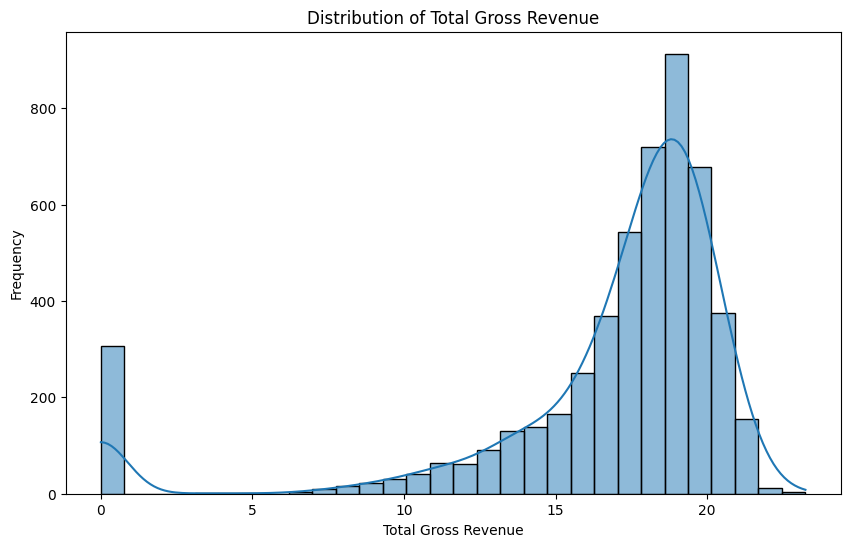

In [8]:
# Plot the distribution of total gross revenue
plt.figure(figsize=(10, 6))
sns.histplot(data['Total Gross'], bins=30, kde=True)
plt.title('Distribution of Total Gross Revenue')
plt.xlabel('Total Gross Revenue')
plt.ylabel('Frequency')

Unexpectedly, there are a huge number of films that have revenue is 0, this can be because, some of films' revenues were not recorded. Therefore, we decided to delete movies having revenue equals to 0

In [9]:
data = data[data['Total Gross'] > 0]

data = data.reset_index(drop=True)

In [10]:
numerical_features = ['Tomatoes CriticScore', 'Tomatoes UserScore',
                      'Production Budget', 'Metascore', 'Meta UserScore']
categorical_features = ['Genre', 'Rating', 'Studio', 'Year', 'Month']


X = data[numerical_features+categorical_features]
y = data['Total Gross']


- Feature selection for numerical columns

In [11]:
X_train_for_select, X_test_for_select, y_train_for_select, y_test_for_select = train_test_split(X, y, test_size=0.2, random_state=42)

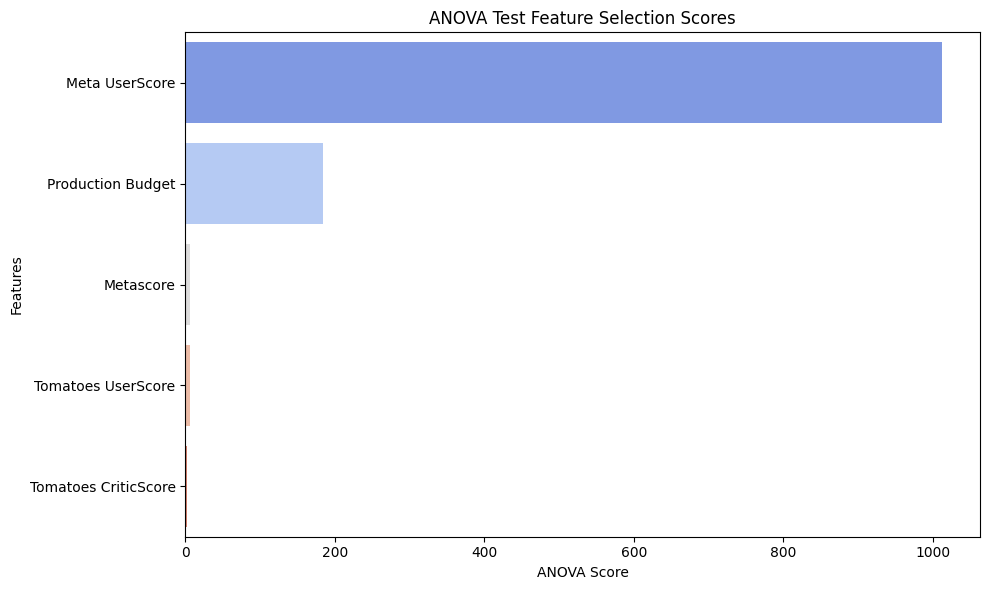

In [12]:
from sklearn.feature_selection import f_classif

X_numerical = X_train_for_select[numerical_features]  # Use column names directly

# Fit SelectKBest with chi2
selector = SelectKBest(f_classif, k=5)
selector.fit(X_numerical, y_train_for_select)

# Get Chi2 scores
scores = pd.DataFrame(data=selector.scores_, index=numerical_features, columns=['score'])
scores = scores.sort_values(by='score', ascending=False)

# Barplot for better visualization
plt.figure(figsize=(10, 6))
sns.barplot(x=scores['score'], y=scores.index, palette='coolwarm', hue=scores.index, legend=False)
plt.title('ANOVA Test Feature Selection Scores')
plt.xlabel('ANOVA Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()


In [13]:
n_director = 10 # One hot encoding for top 10 director with most movies
n_cast = 20 # One hot encoding for top 20 cast with most movies
n_studio = 50 # One hot encoding for top 50 studio with most movies

- Feature selection for categorical columns

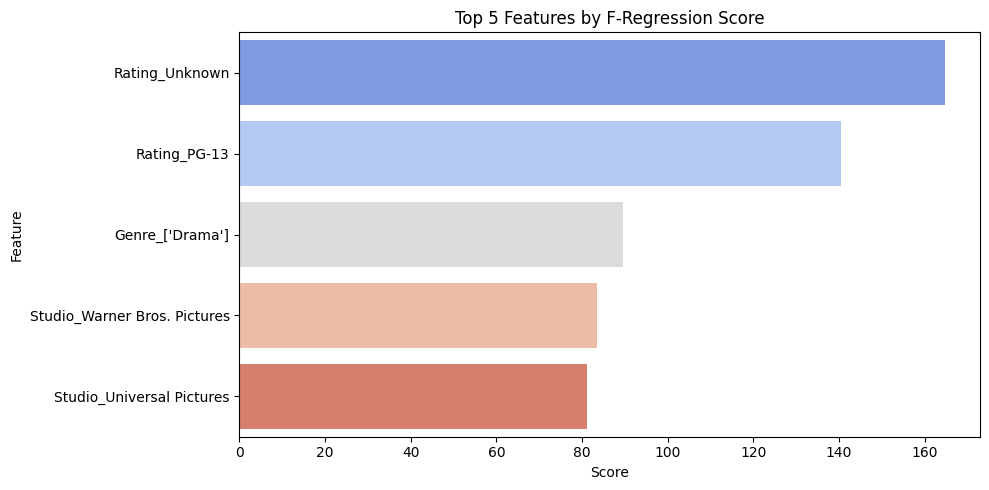

In [14]:
# One-hot encode categorical features

X_categorical = X_train_for_select[categorical_features]  # Use column names directly
X_categorical = X_categorical.fillna(0)

X_categorical_encoded = pd.get_dummies(X_categorical, drop_first=True)

# Fit SelectKBest with f_regression
selector = SelectKBest(f_regression, k=5)
selector.fit(X_categorical_encoded, y_train_for_select)

# Get scores
scores = pd.DataFrame(data=selector.scores_, 
                      index=X_categorical_encoded.columns, 
                      columns=['score'])
scores = scores.sort_values(by='score', ascending=False)

# Get the top 5 features
top_5_categorical = scores.head(5).index.tolist()

# Plot the top 5 scores
plt.figure(figsize=(10, 5))
sns.barplot(y=scores.head(5).index, x=scores.head(5)['score'], palette='coolwarm', hue=scores.head(5).index, legend=False)
plt.title('Top 5 Features by F-Regression Score')
plt.xlabel('Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


As can be seen from the plot, some members of **`Genre`** and **`Rating`** shows up in top 5 F-Regression Score, therefore we will need to include these columns for modelling, however, we don't see any of **`Cast`** and **`Director`**. So we will need to use some plots to see actually whether it has any correlations with revenue

Text(0.5, 0, 'Cast Quality')

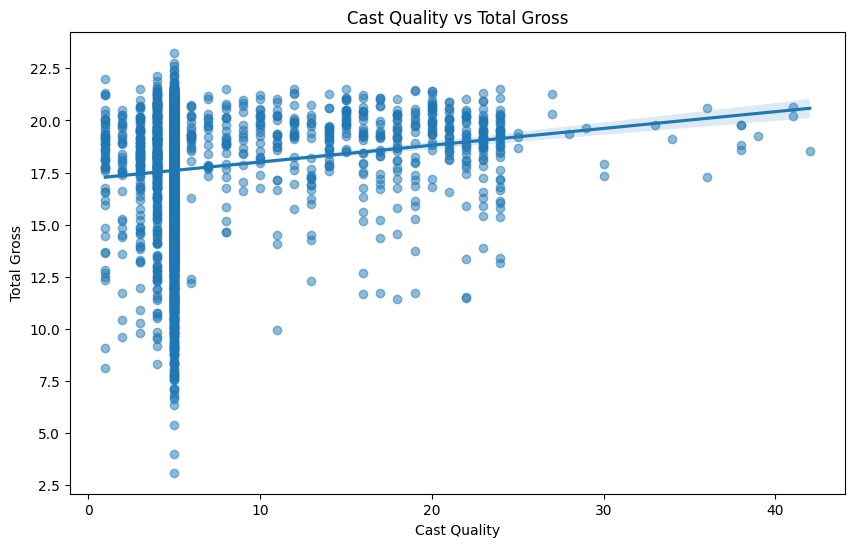

In [15]:
def reformat_cast(cast_string):
    cast_string = cast_string.replace('[','').replace(']','').replace('"','')
    cast_list = [cast.strip().strip("'") for cast in cast_string.split(',')]
    return cast_list


# Create a temporary copy of the data
data_tmp = data.copy()

# Split the 'Cast' column into a list of cast members
data_tmp['Cast'] = data_tmp['Cast'].apply(reformat_cast)

# Get the top 20 cast members
top_cast = data_tmp['Cast'].explode().value_counts().nlargest(20)

# Create a mapping for the top cast members (the more famous cast get higher values)
map_top_cast = {cast: i for i, cast in zip(range(len(top_cast), 0, -1), top_cast.index)}

# Encode the 'Cast' column to calculate the quality of the cast for each movie
def encode_cast(cast):
    quality_score = 0
    # Iterate through each cast member of the movie
    for member in cast:
        # Add the value of the cast member if they are in the top 20
        if member in map_top_cast:
            quality_score += map_top_cast[member]
        else:
            # For members not in the top 20, give them a default score of 1
            quality_score += 1
    return quality_score

# Apply the function to calculate the quality of the cast for each movie
data_tmp['Cast_Quality'] = data_tmp['Cast'].apply(encode_cast)

# Plot the regplot of the 'Cast_Quality' and 'Total Gross' columns
plt.figure(figsize=(10, 6))
sns.regplot(x='Cast_Quality', y='Total Gross', data=data_tmp, scatter_kws={'alpha': 0.5})
plt.title('Cast Quality vs Total Gross')
plt.xlabel('Cast Quality')



In [16]:
print(data_tmp[['Cast_Quality', 'Total Gross']].corr())

              Cast_Quality  Total Gross
Cast_Quality      1.000000     0.133129
Total Gross       0.133129     1.000000


From the scatter plot, we can observe a weak positive trend, as indicated by the regression line, suggesting that there is a small positive correlation between Cast Quality and Total Gross. However, the data points are widely scattered, and the regression line is not steep, which indicates that Cast Quality alone does not strongly predict Total Gross.
Therefore, we will remove it

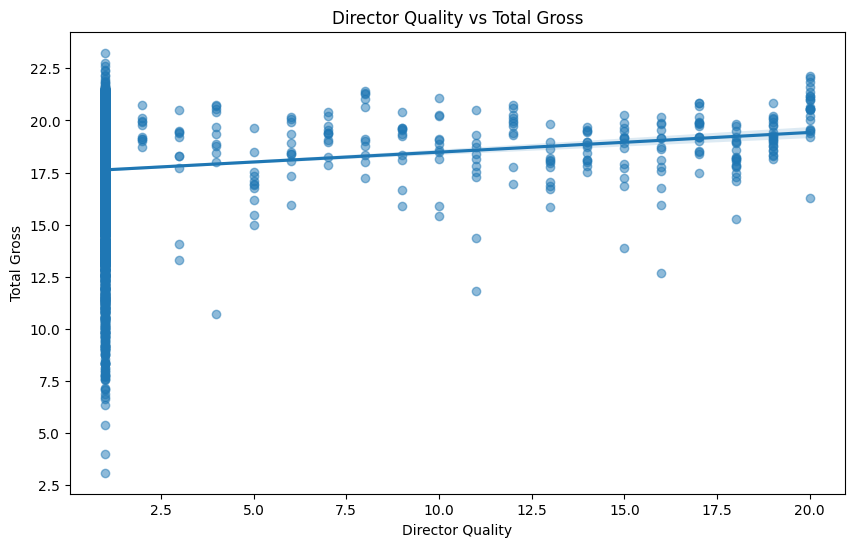

In [17]:
def reformat_director(director_string):
    # Remove unwanted characters and split the director string into a list
    director_string = director_string.replace('[','').replace(']','').replace('"','')
    director_list = [director.strip().strip("'") for director in director_string.split(',')]
    return director_list


# Create a temporary copy of the data
data_tmp = data.copy()

# Split the 'Director' column into a list of directors
data_tmp['Director'] = data_tmp['Director'].apply(reformat_director)

# Get the top 20 directors (most frequent directors)
top_directors = data_tmp['Director'].explode().value_counts().nlargest(20)

# Create a mapping for the top directors (more famous directors get higher values)
map_top_directors = {director: i for i, director in zip(range(len(top_directors), 0, -1), top_directors.index)}

# Encode the 'Director' column to calculate the quality of the director for each movie
def encode_director(directors):
    quality_score = 0
    # Iterate through each director of the movie
    for director in directors:
        # Add the value of the director if they are in the top 20
        if director in map_top_directors:
            quality_score += map_top_directors[director]
        else:
            # For directors not in the top 20, give them a default score of 1
            quality_score += 1
    return quality_score

# Apply the function to calculate the quality of the director for each movie
data_tmp['Director_Quality'] = data_tmp['Director'].apply(encode_director)

# Plot the regplot of the 'Director_Quality' and 'Total Gross' columns
plt.figure(figsize=(10, 6))
sns.regplot(x='Director_Quality', y='Total Gross', data=data_tmp, scatter_kws={'alpha': 0.5})
plt.title('Director Quality vs Total Gross')
plt.xlabel('Director Quality')
plt.ylabel('Total Gross')
plt.show()


In [18]:
print(data_tmp[['Director_Quality', 'Total Gross']].corr())

                  Director_Quality  Total Gross
Director_Quality          1.000000     0.105281
Total Gross               0.105281     1.000000


The scatter plot shows a weak positive correlation between Director Quality and Total Gross. This means that as Director Quality increases, Total Gross tends to increase slightly, but the relationship is not very strong. So, we will remove it as well

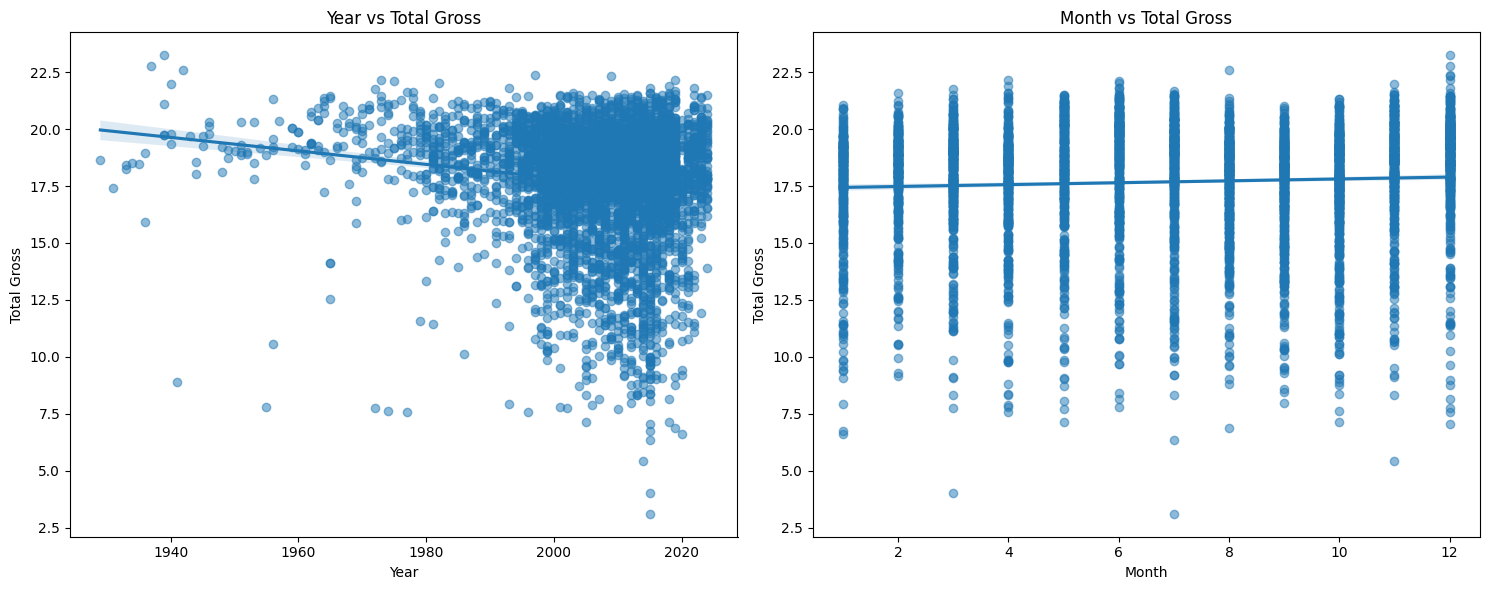

In [19]:
# Create a figure with 2 subplots arranged horizontally
data_tmp = data.copy()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot Year vs Total Gross
sns.regplot(x='Year', y='Total Gross', data=data_tmp, ax=ax1, scatter_kws={'alpha': 0.5})
ax1.set_title('Year vs Total Gross')
ax1.set_xlabel('Year')
ax1.set_ylabel('Total Gross')

# Plot Month vs Total Gross
sns.regplot(x='Month', y='Total Gross', data=data_tmp, ax=ax2, scatter_kws={'alpha': 0.5})
ax2.set_title('Month vs Total Gross')
ax2.set_xlabel('Month')
ax2.set_ylabel('Total Gross')

plt.tight_layout()
plt.show()

In [20]:
print(data_tmp[['Year', 'Total Gross']].corr())
print(data_tmp[['Month', 'Total Gross']].corr())

                 Year  Total Gross
Year         1.000000    -0.144945
Total Gross -0.144945     1.000000
                Month  Total Gross
Month        1.000000     0.054402
Total Gross  0.054402     1.000000


Although, the correlation between Year and Month and Total Gross is weak, we still keep it because both features relevant for movie industry. But we need to modify it into bin to reduce potential noise while preserving temporal information

- Categorical encoding and numerical scaling

1. Handling Missing Values
2. Reforming and encoding Categorical Variables
    - **`Genre`** is reformatted from a string representation of a list to an actual list of genres. Then, one-hot encoding is applied to each unique genre
    - **`Rating`** is one-hot encoded using OneHotEncoder
    - **`Studio`** is one-hot encoded for the top n_studio studios (Which movie produced by top studio (has the top highest number of movies produced) is labeled 1 ), with other studios grouped into 'Studio Other'
    - **`Director`** and **`Cast`** are one-hot encoded as the same for **`Studio`**, although we don't use this feature, we still leave there if needed in future
    - **`Year`** and **`Month`** are binned into 10 years and 3 months respectively, to catch the trend of movies 

In [21]:
data = data.dropna(subset=['Total Gross'])

def reformat_genre(genre_string):
    genre_string = genre_string.replace('[','').replace(']','').replace('"','')
    genre_list = [genre.strip().strip("'") for genre in genre_string.split(',')]
    return genre_list

X['Genre'] = X['Genre'].apply(reformat_genre)

#Get unique
unique_genres = set(genre for sublist in X['Genre'] for genre in sublist)

#One hot encoding Genre
for genre in unique_genres:
    X[f'Genre_{genre}'] = X['Genre'].apply(lambda x: 1 if genre in x else 0)

X = X.drop(columns=['Genre'])

#One hot encoding Rating
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_features = encoder.fit_transform(X[['Rating']])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['Rating']))

X = pd.concat([X, encoded_df], axis=1).drop(['Rating'], axis=1)

if 'Studio' in X.columns:

  n_tops = n_studio

  top_studios = X['Studio'].value_counts().nlargest(n_tops)
  X['Studio'] = X['Studio'].apply(lambda x: x if x in top_studios else 'Studio Other')
  encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
  encoded_features = encoder.fit_transform(X[['Studio']])
  encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['Studio']))
  X = pd.concat([X, encoded_df], axis=1).drop(['Studio'], axis=1)

if 'Director' in X.columns:

  n_top = n_director

  top_directors = X['Director'].value_counts().nlargest(n_top)
  X['Director'] = X['Director'].apply(lambda x: x if x in top_directors else 'Director Other')
  encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
  encoded_features = encoder.fit_transform(X[['Director']])
  encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['Director']))
  X = pd.concat([X, encoded_df], axis=1).drop(['Director'], axis=1)

def bin_years(data, column, bins=11, future_year=2024):
    """
    Bin years with padding for future years
    """
    min_year = data[column].min()
    max_year = max(data[column].max(), future_year)  # Include 2024
    
    bin_edges = np.linspace(min_year, max_year, bins + 1)
    bin_labels = [f"{int(bin_edges[i])}-{int(bin_edges[i+1])}" for i in range(len(bin_edges) - 1)]
    binned_years = pd.cut(data[column], bins=bin_edges, labels=bin_labels, include_lowest=True)
    return binned_years

if 'Year' in X.columns:
    n_bins = 11
    
    X['Year'] = bin_years(X, 'Year', bins=n_bins, future_year=2024)
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    encoded_features = encoder.fit_transform(X[['Year']])
    encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['Year']))
    X = pd.concat([X, encoded_df], axis=1).drop(['Year'], axis=1)

#Reformat cast string into list
def reformat_cast(cast_string):
    if pd.isna(cast_string):
        return []
    cast_string = cast_string.replace('[','').replace(']','').replace('"','')
    cast_list = [cast.strip().strip("'") for cast in cast_string.split(',')]
    return cast_list

if 'Cast' in X.columns:

  n_top = n_cast  #Perform one hot for n_cast with most movies

  X['Cast'] = X['Cast'].apply(reformat_cast)
  top_cast = X['Cast'].explode().value_counts().nlargest(n_top)
  for cast in top_cast.index:
      X[f'Cast_{cast}'] = X['Cast'].apply(lambda x: 1 if cast in x else 0)
  X = X.drop(columns=['Cast'])
  
def bin_months(data, column):
    """
    Bin months with special handling for winter months (December-January)
    """
    def assign_month_group(month):
        if month in [12, 11, 1]:
            return '11_1'
        elif month in [2, 3, 4]:
            return '2_4'
        elif month in [5, 6, 7]:
            return '5_7'
        elif month in [8, 9, 10]:
            return '8_10'
    
    return data[column].apply(assign_month_group)

if 'Month' in X.columns:
  
    #Perform one hot encoding
  X['Month'] = bin_months(X, 'Month')
  encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
  encoded_features = encoder.fit_transform(X[['Month']])
  encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['Month']))
  X = pd.concat([X, encoded_df], axis=1).drop(['Month'], axis=1)
  
# Standard scaler for numerical features
scaler_for_x = StandardScaler()
scaler_for_y = StandardScaler()
X[numerical_features] = scaler_for_x.fit_transform(X[numerical_features])
y = scaler_for_y.fit_transform(y.values.reshape(-1, 1)).flatten()


In [22]:
X.to_csv('test.csv', index=False)

<h1 id = "modelling">4. Modelling</h1>

- XGBoost

In [23]:
result = [] # Store the results of each model

In [24]:

xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3,
                   random_state=42, objective='reg:squarederror')

X.columns = [col.replace('[', '').replace(']', '').replace('<', '').replace('>', '') for col in X.columns]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Model XGBoost")
print('MAE:', mae)
print('MSE:', mse)
print('R2:', r2)

# Using KFold
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(xgb, X, y, scoring='r2', cv=cv)
print('Mean R2:', np.mean(scores))

result.append({'model': 'XGBoost', 'MAE': mae, 'MSE': mse, 'R2': r2, 'Mean R2': np.mean(scores)})

Model XGBoost
MAE: 0.42600095799914556
MSE: 0.3791553773079882
R2: 0.6348019394667863
Mean R2: 0.611196561219705


- Gradient Boosting Regressor

In [25]:

from sklearn.ensemble import GradientBoostingRegressor

gbg = GradientBoostingRegressor(random_state=42)

gbg.fit(X_train, y_train)
y_pred = gbg.predict(X_test)

# 8. Đánh giá kết quả
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('MAE:', mae)
print('MSE:', mse)
print('R2:', r2)

# Using KFold
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(gbg, X, y, scoring='r2', cv=cv)
print('Mean R2:', np.mean(scores))

result.append({'model': 'GradientBoosting', 'MAE': mae, 'MSE': mse, 'R2': r2, 'Mean R2': np.mean(scores)})

MAE: 0.4279096334736602
MSE: 0.38644466813765577
R2: 0.6277809791086408
Mean R2: 0.609137365404959


- Decision Tree Regressor

In [26]:
from sklearn.tree import DecisionTreeRegressor

# Now directly create the model
dt = DecisionTreeRegressor(random_state=42, criterion='squared_error')

dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Model Decision Tree")
print('MAE:', mae)
print('MSE:', mse)
print('R2:', r2)

# Using KFold
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(dt, X, y, scoring='r2', cv=cv)
print('Mean R2:', np.mean(scores))

result.append({'model': 'DecisionTree', 'MAE': mae, 'MSE': mse, 'R2': r2, 'Mean R2': np.mean(scores)})

Model Decision Tree
MAE: 0.5807080951782124
MSE: 0.7461162580045064
R2: 0.2813494765914696
Mean R2: 0.19432439240448382


- Random Forest Regressor

In [27]:
from sklearn.ensemble import RandomForestRegressor

# Now directly create the model
rf = RandomForestRegressor(random_state=42, criterion='squared_error')

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Model Random Forest")
print('MAE:', mae)
print('MSE:', mse)
print('R2:', r2)

# Using KFold
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(rf, X, y, scoring='r2', cv=cv)
print('Mean R2:', np.mean(scores))

# Store the results of each model
result.append({'model': 'RandomForest', 'MAE': mae, 'MSE': mse, 'R2': r2, 'Mean R2': np.mean(scores)})

Model Random Forest
MAE: 0.425483634516543
MSE: 0.3831993505716717
R2: 0.6309068313366286
Mean R2: 0.5892218894161327


Let try hyper-tuning process, in this case, we will use **GridSearchCV**, because:
1. **Exhaustive Search**: GridSearchCV performs an exhaustive search over the specified parameter grid, ensuring that all possible combinations of hyperparameters are evaluated.
2. **Cross-Validation**: It uses cross-validation to evaluate the performance of each combination of hyperparameters, providing a robust estimate of model performance.
3. **Parallel Processing**: GridSearchCV supports parallel processing, allowing for faster computation by utilizing multiple CPU cores.
4. **Automatic Best Parameter Selection**: It automatically selects the best combination of hyperparameters based on the specified scoring metric.


- XGBoost with GridSearchCV

In [28]:
from sklearn.model_selection import GridSearchCV, cross_val_score

param_grid = {
    'n_estimators': [50, 100, 200],          # No. of trees
    'max_depth': [3, 6, 9],                   # Max depth of trees
    'learning_rate': [0.01, 0.1, 0.2],       # Learning rate
    'subsample': [0.8, 1.0],                  # Sample of dataset
    'colsample_bytree': [0.8, 1.0]            # Sample of columns
}

# Now directly create the model
xgb_cv = XGBRegressor(random_state=42, objective='reg:squarederror')

grid_search = GridSearchCV(xgb_cv, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train)
xgb_cv_model = grid_search.best_estimator_
y_pred = xgb_cv_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = xgb_cv_model.score(X_test, y_test)
mae = mean_absolute_error(y_test, y_pred)

print('Model XGBoost with GridSearchCV') 
print('MAE:', mae)
print('MSE:', mse)
print('R2:', r2)

# Using KFold
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(xgb_cv_model, X, y, scoring='r2', cv=cv)
print('Mean R2:', np.mean(scores))

# Store the results of each model
result.append({'model': 'XGBoost with GridSearchCV', 'MAE': mae, 'MSE': mse, 'R2': r2, 'Mean R2': np.mean(scores)})

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Model XGBoost with GridSearchCV
MAE: 0.417948710369228
MSE: 0.3666245435874306
R2: 0.6468714931260361
Mean R2: 0.6236665085027524


- Gradient Boosting Regressor with GridSearchCV

In [29]:
param_grid = {
    'n_estimators': [50, 100, 200],          # No of trees
    'max_depth': [3, 5, 7],                  # Depth of tree
    'learning_rate': [0.01, 0.05, 0.1],      # Learning rate
    'subsample': [0.8, 1.0],                 # Sample ratio
}

# Initialize the model
gbg_cv = GradientBoostingRegressor(random_state=42)

# Initialize GridSearchCV without the 'model__' prefix
grid_search = GridSearchCV(gbg_cv, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Best model found by GridSearchCV
gbg_cv_model = grid_search.best_estimator_

# Make predictions
y_pred = gbg_cv_model.predict(X_test)

# Evaluate performance
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = gbg_cv_model.score(X_test, y_test)

print('MAE:', mae)
print('MSE:', mse)
print('R2:', r2)

# Using KFold for cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(gbg_cv_model, X, y, scoring='r2', cv=cv)
print('Mean R2:', np.mean(scores))

# Store the results of each model
result.append({'model': 'GradientBoosting with GridSearchCV', 'MAE': mae, 'MSE': mse, 'R2': r2, 'Mean R2': np.mean(scores)})

Fitting 5 folds for each of 54 candidates, totalling 270 fits
MAE: 0.41287871364430556
MSE: 0.3610637792550407
R2: 0.6522275568160454
Mean R2: 0.6197715993026719


- Decision Tree Regressor with GridSearchCV

In [30]:
param_grid = {
    'max_depth': [3, 6, 9],                   # Max depth of trees
    'min_samples_split': [2, 5, 10],          # Min samples to split
    'min_samples_leaf': [1, 2, 4]             # Min samples in leaf
}

dt_cv = DecisionTreeRegressor(random_state=42)

grid_search = GridSearchCV(dt_cv, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train)
dt_cv_model = grid_search.best_estimator_
y_pred = dt_cv_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = dt_cv_model.score(X_test, y_test)
mae = mean_absolute_error(y_test, y_pred)

print('Model Decision Tree with GridSearchCV')
print('MAE:', mae)
print('MSE:', mse)
print('R2:', r2)

# Using KFold
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(dt_cv_model, X, y, scoring='r2', cv=cv)
print('Mean R2:', np.mean(scores))

# Store the results of each model
result.append({'model': 'DecisionTree with GridSearchCV', 'MAE': mae, 'MSE': mse, 'R2': r2, 'Mean R2': np.mean(scores)})

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Model Decision Tree with GridSearchCV
MAE: 0.4905593975703934
MSE: 0.4892689162773502
R2: 0.5287418562482008
Mean R2: 0.5087785382191068


- Random Forest with GridSearchCV

In [31]:
param_grid = {
    'n_estimators': [50, 100, 200],          # No of trees
    'max_depth': [3, 6, 9],                   # Max depth of trees
    'min_samples_split': [2, 5, 10],          # Min samples to split
    'min_samples_leaf': [1, 2, 4]             # Min samples in leaf
}
rf_cv = RandomForestRegressor(random_state=42, criterion='squared_error')

grid_search = GridSearchCV(rf_cv, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train)

rf_cv_model = grid_search.best_estimator_
y_pred = rf_cv_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = rf_cv_model.score(X_test, y_test)
mae = mean_absolute_error(y_test, y_pred)

print('Model Random Forest with GridSearchCV')
print('MAE:', mae)
print('MSE:', mse)
print('R2:', r2)

# Using KFold
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(rf_cv_model, X, y, scoring='r2', cv=cv)
print('Mean R2:', np.mean(scores))

# Store the results of each model
result.append({'model': 'RandomForest with GridSearchCV', 'MAE': mae, 'MSE': mse, 'R2': r2, 'Mean R2': np.mean(scores)})

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Model Random Forest with GridSearchCV
MAE: 0.44110490185796525
MSE: 0.4106123098342829
R2: 0.6045029870149127
Mean R2: 0.5849220375805311


In [32]:
# Convert the result list to a DataFrame and save it to a CSV file
result_df = pd.DataFrame(result)
result_df.to_csv('result.csv', index=False)

<h1 id = "evaluation">5. Evaluation</h1>

#### Steps:
1. Introduction to types of metrics that used
2. Plot the distribution of metrics among models
3. Plot the predicted values vs true values of each model
4. Compare and point out disadvantages and advantages of each model (Emphasize on without and with using hyper-tuning)
5. Deploy with real test case (input) with all models and compare the differences
6. Which model is the best and why ?

##### 1. Introduction to types of metrics that used

| Metric | Description | Advantages | Disadvantages |
|--------|-------------|-------------|---------------|
| **Mean Absolute Error (MAE)** |Measures the average magnitude of the errors in a set of predictions, without considering their direction. |- Easy to interpret as it represents the average error in the same units as the target variable. <br> - Less sensitive to outliers compared to MSE. | - Not differentiable at zero, which can make it difficult to use with some optimization algorithms. <br> - Treats all errors equally, which might not be desirable in some contexts. |
| **Mean Squared Error (MSE)** |Measures the average of the squares of the errors. It is more sensitive to outliers than MAE. |- Differentiable, making it suitable for gradient-based optimization algorithms. <br> - Penalizes larger errors more heavily, which can be useful if larger errors are particularly undesirable. | - More sensitive to outliers because it squares the errors, which can disproportionately affect the metric. <br> - The units of MSE are the square of the target variable's units, which can make it less interpretable. |
| **R-squared (R2)** | Represents the proportion of the variance for a dependent variable that's explained by an independent variable or variables in a regression model.|- Represents the proportion of variance explained by the model, which is easy to interpret. <br> - Useful for comparing the goodness-of-fit of different models. | - Can be misleading for non-linear models. <br> - High R2 does not necessarily mean a good model; it can be high due to overfitting. <br> - Can be negative if the model performs worse than a horizontal line (mean of the target variable). |

#### 2. Plot the distribution of metrics among models

#### 3. Plot the predicted values vs true values of each model

#### 4. Compare and point out disadvantages and advantages of each model (Emphasize on without and with using hyper-tuning)

| Model Name | Advantages (Without Tuning) | Disadvantages (Without Tuning) | Advantages (With Tuning) | Disadvantages (With Tuning)
|------------|---------------------------|--------------------------------|----------------------------|----------------------------|
| **XGBoost** | - Strong default performance due to powerful boosting mechanism. <br> - Handles missing data well (built-in mechanism). | - Prone to overfitting if parameters like max_depth, learning_rate are not tuned. <br> - Training time can be slower than other models with large datasets. | - Significantly optimized performance, especially on large datasets. <br> - Supports various optimization options, improving generalization. | - Resource-intensive tuning, requiring knowledge of parameters like n_estimators, max_depth, subsample, colsample_bytree. <br> - Can overfit to validation data if tuning is overdone. |
| **Gradient Boosting** | - Easy to implement, performs reasonably well with medium or small datasets. <br> - Suitable for regression or classification tasks with non-linear data. | - Performance may degrade on large datasets or without optimized parameters. <br> - Sensitive to outliers due to the lack of robust mechanisms for handling them. | - Increases accuracy by tuning learning_rate, n_estimators, and subsample. <br> - More flexible, minimizing overfitting/underfitting with better parameter control. | - Slower tuning process for large datasets due to sequential training nature. <br> - Challenging to manage if the importance of key parameters is not well understood. |
| **Decision Tree** | - Very fast, interpretable, no need for data normalization. <br> - Ideal for small tasks or when interpretability is crucial. | - Poor performance on complex data, prone to overfitting with default settings. <br> - Ineffective for large datasets, does not handle noisy or missing data well. | - Optimizing max_depth and min_samples_split significantly reduces overfitting. <br> - Can show noticeable improvement on small datasets after tuning. | - Overall performance still lags behind ensemble models (RF, XGB). <br> - Limited scalability for large or complex datasets. |
| **Random Forest** | - Stable performance, less prone to overfitting due to ensemble of multiple trees. <br> - Versatile, handles non-linear data well. | - Default parameters (n_estimators=100, max_depth=None) may lead to underfitting. <br> - Less interpretable compared to Decision Tree. | - Extremely robust when optimizing n_estimators, max_depth, and max_features. <br> - Suitable for large datasets, reduces sensitivity to outliers via averaging predictions across multiple trees. | - Computationally expensive to tune (many trees and parameter combinations). <br> - Training time can be significantly higher if n_estimators is set too high. |

**Conclusion**
- Without tuning:
    - Fast and sufficient for quick insights.
    - Performance may be suboptimal for complex datasets.
- With tuning:
    - Enhances performance significantly, especially for more sophisticated models like XGBoost and Gradient Boosting.
    - Requires more computational resources and expertise in parameter adjustment.

#### 5. Deploy with real test case (input) with all models and compare the differences


#### 6. Which model is the best and why ?

- Column R2 is dropped as the focus is on Mean R2

In [33]:
result_df = result_df.drop(columns=['R2'])

In [34]:

print("Model with the best MAE:")
display(result_df.sort_values(by='MAE', ascending=True).head(1))
print("Model with the best MSE:")
display(result_df.sort_values(by='MSE', ascending=True).head(1))
print("Model with the best Mean R2:")
display(result_df.sort_values(by='Mean R2', ascending=False).head(1))

Model with the best MAE:


,model,MAE,MSE,Mean R2
5,GradientBoosting with GridSearchCV,0.412879,0.361064,0.619772


Model with the best MSE:


,model,MAE,MSE,Mean R2
5,GradientBoosting with GridSearchCV,0.412879,0.361064,0.619772


Model with the best Mean R2:


,model,MAE,MSE,Mean R2
4,XGBoost with GridSearchCV,0.417949,0.366625,0.623667


→ The two best models that can be compared are: GradientBoosting with GridSearchCV and XGBoost with GridSearchCV	

In [35]:
from scipy.stats import ttest_rel

mean_r2_model1 = cross_val_score(xgb_cv_model, X, y, scoring='r2', cv=cv)
mean_r2_model2 = cross_val_score(gbg_cv_model, X, y, scoring='r2', cv=cv)

t_stat, p_val = ttest_rel(mean_r2_model1, mean_r2_model2)
print("Paired t-test p-value:", p_val)

if p_val < 0.05: 
    print("The difference between the models is statistically significant.")
else:
    print("The difference between the models is not statistically significant.")

Paired t-test p-value: 0.416621621550864
The difference between the models is not statistically significant.


→ The difference in Mean R2 between the two models is not statistically significant, meaning there is almost no difference in scores between these two models.

#### **A comprehensive comparison of two models: Gradient Boosting with GridSearchCV and XGBoost with GridSearchCV.**
1. **Prediction Performance (MAE, MSE, Mean R²)**

    - MAE (Mean Absolute Error):
        - GradientBoosting: ~ 0.414 (1% better)
        - XGBoost: ~ 0.418 

    - MSE (Mean Squared Error):
        - GradientBoosting: ~ 0.364 (1% better)
        - XGBoost: ~ 0.368

    - Mean R²:
        - GradientBoosting: ~ 0.619
        - XGBoost: ~ 0.622 (0.5% better)

    - Analysis:
        - MAE and MSE:
            - GradientBoosting has slightly lower MAE and MSE, but the difference is still small (~ 1%), meaning the model tends to make slightly more accurate predictions with smaller errors.
        - Mean R²:
            - XGBoost has a slightly higher Mean R², but the difference is still small (~ 0.5%). This indicates that XGBoost explains a marginally higher proportion of the variance in the data, but the difference is statistically insignificant (most p-value > 0.05).

2. **Training Time**
    - XGBoost with GridSearchCV: ~ 18s
    - GradientBoosting with GridSearchCV: ~ 35s
    - Analysis:
        - XGBoost is now almost twice as fast as GradientBoosting in training time (18s vs. 35s). This makes XGBoost significantly more efficient, especially when multiple models are being trained or when there are time constraints for model iteration.

3. **Stability and Reproducibility (Cross-validation)**
    - Both models were run with GridSearchCV, which optimizes hyperparameters and ensures stable performance across different data folds. The results show that both models exhibit consistent performance across cross-validation.

4. **Ease of Deployment and Maintenance**
    - XGBoost: Due to its faster training time and efficient hyperparameter optimization, XGBoost is often more suitable in production environments where model training speed is important.
    - GradientBoosting: While it provides slightly more accurate predictions, its longer training time can make it less practical when quick results or frequent model updates are needed.

#### **Conclusion**:
1. **Prediction Performance**:
    - GradientBoosting has slightly lower MAE and MSE, indicating it can achieve marginally more accurate predictions. However, the difference in prediction accuracy between the two models is small and likely negligible in most practical scenarios.
    - XGBoost performs similarly with a slightly higher Mean R², but the difference is very minor and statistically insignificant.
2. **Training Time**:
    - XGBoost is significantly faster than GradientBoosting, with training times of 18s compared to 35s. This makes XGBoost more efficient for rapid iterations or deployment, especially when working with larger datasets.
3. **Final Decision**:
    - XGBoost offers almost identical performance to GradientBoosting in terms of prediction accuracy but is much faster in training, making it the better choice for time-sensitive tasks or larger datasets.

**→ Thus, XGBoost stands out as the better choice when considering both model performance and efficiency.**